The idea of this notebook is to provide one plot showing that greedy faasta (combining Gale and Jingwei's ideas) is still slower than Condat for an analysis reconstruction problem with undecimated wavelets.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib nbagg

# Third party import
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
from tqdm import tqdm_notebook

# Package import
from modopt.math.metrics import ssim
from modopt.opt.linear import Identity
from modopt.opt.proximity import SparseThreshold, LinearCompositionProx, LinearCompositionIterativeProx
from mri.numerics.fourier import FFT2, NFFT
from mri.numerics.gradient import GradAnalysis2
from mri.numerics.linear import Wavelet2, WaveletUD
from mri.numerics.reconstruct import sparse_rec_fista, sparse_rec_condatvu
from mri.numerics.utils import convert_mask_to_locations
import pysap
from pysap.data import get_sample_data

np.random.seed(0)


                 .|'''|       /.\      '||'''|,
                 ||          // \\      ||   ||
'||''|, '||  ||` `|'''|,    //...\\     ||...|'
 ||  ||  `|..||   .   ||   //     \\    ||
 ||..|'      ||   |...|' .//       \\. .||
 ||       ,  |'
.||        ''

Package version: 0.0.3

License: CeCILL-B

Authors: 

Antoine Grigis <antoine.grigis@cea.fr>
Samuel Farrens <samuel.farrens@cea.fr>
Jean-Luc Starck <jl.stark@cea.fr>
Philippe Ciuciu <philippe.ciuciu@cea.fr>

Dependencies: 

scipy          : >=0.18.0  - required | 1.3.0     installed
numpy          : >=1.11.0  - required | 1.16.3    installed
matplotlib     : >=2.0.0   - required | 3.1.0     installed
future         : >=0.16.0  - required | 0.17.1    installed
astropy        : ==2.0.8   - required | 2.0.8     installed
nibabel        : >=2.1.0   - required | 2.4.0     installed
pyqtgraph      : >=0.10.0  - required | 0.10.0    installed
progressbar2   : >=3.34.3  - required | ?         installed
modopt         : >=1.1.5   - requi

#  Loading input data

In [2]:
image = get_sample_data("mri-slice-nifti")
original_image_data = np.copy(image.data)
image.data += np.random.randn(*image.shape) * 20.
image.data = image.data.astype(np.complex128)
mask = get_sample_data("mri-mask")

In [3]:
non_cartesian = True
sparkling = True

# Generate the kspace 
From the 2D brain slice and the acquistion mask, we generate the acquisition measurments, the observed kspace. We then reconstruct the zero order solution.

In [4]:
# potential path to sparkling trajectory
sparkling_traj_file_path = '../personal_experiments/2019-Mar-01_N512_nc34_ns3073_OS1_decim64_decay2_tau0.75_nrevol1/samples_SPARKLING_N512_nc34x3073_OS1.mat'

In [5]:
# Generate the subsampled kspace
if non_cartesian:
    if sparkling:
        kspace_loc = scipy.io.loadmat(sparkling_traj_file_path)['samples']
    else:
        kspace_loc = convert_mask_to_locations(mask.data)
    fourier_op = NFFT(samples=kspace_loc, shape=image.shape)
    kspace_data = fourier_op.op(image.data)

    # Zero order solution
    image_rec0 = pysap.Image(data=fourier_op.adj_op(kspace_data), metadata=image.metadata)
else:
    kspace_mask = np.fft.ifftshift(mask.data)
    kspace_loc = convert_mask_to_locations(kspace_mask)
    fourier_op = FFT2(samples=kspace_loc, shape=image.shape)
    kspace_data = fourier_op.op(image.data)

    # Zero order solution
    image_rec0 = pysap.Image(data=fourier_op.adj_op(kspace_data), metadata=image.metadata)

/volatile/home/Zaccharie/workspace/pysap-mri/mri/reconstruct/fourier.py:172: UserWarning: Samples will be normalized between [-0.5; 0.5[
  warnings.warn("Samples will be normalized between [-0.5; 0.5[")
/volatile/home/Zaccharie/workspace/pysap-mri/mri/reconstruct/utils.py:103: UserWarning: Frequency equal to 0.5 will be put in -0.5
  warnings.warn("Frequency equal to 0.5 will be put in -0.5")


# Operators

In [6]:
nb_scales = 4
wavelet_id = 2

In [7]:
linear_op = WaveletUD(
    nb_scale=nb_scales,
    wavelet_id=wavelet_id,
    coarse=False,
    set_norm=1.1,
)

gradient_op = GradAnalysis2(
    data=kspace_data,
    fourier_op=fourier_op)

prox_op_iterative = LinearCompositionIterativeProx(
    linear_op=linear_op,
    prox_op=SparseThreshold(Identity(), None, thresh_type="soft"),
    max_precision_level=150,
    solver_sigma=10.0,
)

prox_op_condat = SparseThreshold(linear_op, None, thresh_type="soft")

cost_op = None

# FAASTA optimization
We now want to refine the zero order solution using a FAASTA optimization.

In [8]:
def objective_cost(x):
    return data_fidelity(x) + sparsity(x)

def sparsity(x):
    return mu * np.sum(np.abs(linear_op.op(x)))

def data_fidelity(x):
    return 0.5 * np.linalg.norm(fourier_op.op(x) - kspace_data)**2

In [9]:
def nrmse(x):
    return np.linalg.norm(x - original_image_data) / np.mean(original_image_data)

In [10]:
metrics_ = {
    "cost": {"metric": objective_cost, "mapping": {"x_new": "x"}, "cst_kwargs": {}, "early_stopping": False},
    "nrmse": {"metric": nrmse, "mapping": {"x_new": "x"}, "cst_kwargs": {}, "early_stopping": False},
}

In [11]:
mu = 15.0

In [12]:
max_iter = 1000

In [13]:
# Start the FISTA reconstruction
cost_op = None

_, _, _, metrics_iterative = sparse_rec_fista(
    gradient_op=gradient_op,
    linear_op=Identity(),
    prox_op=prox_op_iterative,
    cost_op=cost_op,
    xi_restart=0.96,
    s_greedy=1.1,
    mu=mu,
    restart_strategy='greedy',
    pov='analysis',
    iterative_prox=True,
    max_nb_of_iter=max_iter,
    metrics=metrics_,
    metric_call_period=1,
    verbose=1,
    adaptative_precision=True,
    precision_increase_rate=1.01,
    initial_precision_level=5,
)


  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  15.0
 - lipschitz constant:  95.5108226538341
 - data:  (512, 512)
 - max iterations:  1000
 - image variable shape:  (512, 512)
 - alpha variable shape:  (512, 512)
----------------------------------------
Starting optimization...


N/A% (0 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--WARNING: Making input data immutable.
  0% (1 of 1000) |                       | Elapsed Time: 0:00:02 ETA:   0:37:19WARNING: Making input data immutable.
  0% (2 of 1000) |                       | Elapsed Time: 0:00:04 ETA:   0:38:51WARNING: Making input data immutable.
  0% (3 of 1000) |                       | Elapsed Time: 0:00:06 ETA:   0:37:55WARNING: Making input data immutable.
  0% (4 of 1000) |                       | Elapsed Time: 0:00:09 ETA:   0:38:32WARNING: Making input data immutable.
  0% (5 of 1000) |                       | Elapsed Time: 0:00:11 ETA:   0:38:02WARNING: Making input data immutable.
  0% (6 of 1000) |                       | Elapsed Time: 0:00:13 ETA:   0:39:09WARNING: Making input data immutable.
  0% (7 of 1000) |                       | Elapsed Time: 0:00:16 ETA:   0:38:18WARNING: Making input data immutable.
  0% (8 of 1000) |                       | Elapsed Time: 0:00:18

  7% (70 of 1000) |#                     | Elapsed Time: 0:02:37 ETA:   0:36:21WARNING: Making input data immutable.
  7% (71 of 1000) |#                     | Elapsed Time: 0:02:40 ETA:   0:36:57WARNING: Making input data immutable.
  7% (72 of 1000) |#                     | Elapsed Time: 0:02:42 ETA:   0:33:35WARNING: Making input data immutable.
  7% (73 of 1000) |#                     | Elapsed Time: 0:02:44 ETA:   0:32:01WARNING: Making input data immutable.
  7% (74 of 1000) |#                     | Elapsed Time: 0:02:46 ETA:   0:32:33WARNING: Making input data immutable.
  7% (75 of 1000) |#                     | Elapsed Time: 0:02:48 ETA:   0:32:24WARNING: Making input data immutable.
  7% (76 of 1000) |#                     | Elapsed Time: 0:02:50 ETA:   0:34:07WARNING: Making input data immutable.
  7% (77 of 1000) |#                     | Elapsed Time: 0:02:53 ETA:   0:34:56WARNING: Making input data immutable.
  7% (78 of 1000) |#                     | Elapsed Time: 0:02:55

 14% (140 of 1000) |##                   | Elapsed Time: 0:05:13 ETA:   0:32:02WARNING: Making input data immutable.
 14% (141 of 1000) |##                   | Elapsed Time: 0:05:15 ETA:   0:31:17WARNING: Making input data immutable.
 14% (142 of 1000) |##                   | Elapsed Time: 0:05:17 ETA:   0:31:30WARNING: Making input data immutable.
 14% (143 of 1000) |###                  | Elapsed Time: 0:05:19 ETA:   0:32:25WARNING: Making input data immutable.
 14% (144 of 1000) |###                  | Elapsed Time: 0:05:21 ETA:   0:30:03WARNING: Making input data immutable.
 14% (145 of 1000) |###                  | Elapsed Time: 0:05:24 ETA:   0:31:27WARNING: Making input data immutable.
 14% (146 of 1000) |###                  | Elapsed Time: 0:05:26 ETA:   0:30:46WARNING: Making input data immutable.
 14% (147 of 1000) |###                  | Elapsed Time: 0:05:28 ETA:   0:34:23WARNING: Making input data immutable.
 14% (148 of 1000) |###                  | Elapsed Time: 0:05:31

 21% (210 of 1000) |####                 | Elapsed Time: 0:07:48 ETA:   0:30:52WARNING: Making input data immutable.
 21% (211 of 1000) |####                 | Elapsed Time: 0:07:50 ETA:   0:31:01WARNING: Making input data immutable.
 21% (212 of 1000) |####                 | Elapsed Time: 0:07:53 ETA:   0:29:22WARNING: Making input data immutable.
 21% (213 of 1000) |####                 | Elapsed Time: 0:07:55 ETA:   0:28:36WARNING: Making input data immutable.
 21% (214 of 1000) |####                 | Elapsed Time: 0:07:57 ETA:   0:27:21WARNING: Making input data immutable.
 21% (215 of 1000) |####                 | Elapsed Time: 0:07:59 ETA:   0:27:51WARNING: Making input data immutable.
 21% (216 of 1000) |####                 | Elapsed Time: 0:08:01 ETA:   0:27:20WARNING: Making input data immutable.
 21% (217 of 1000) |####                 | Elapsed Time: 0:08:03 ETA:   0:28:22WARNING: Making input data immutable.
 21% (218 of 1000) |####                 | Elapsed Time: 0:08:05

 28% (280 of 1000) |#####                | Elapsed Time: 0:10:24 ETA:   0:28:07WARNING: Making input data immutable.
 28% (281 of 1000) |#####                | Elapsed Time: 0:10:26 ETA:   0:28:30WARNING: Making input data immutable.
 28% (282 of 1000) |#####                | Elapsed Time: 0:10:29 ETA:   0:28:23WARNING: Making input data immutable.
 28% (283 of 1000) |#####                | Elapsed Time: 0:10:31 ETA:   0:27:36WARNING: Making input data immutable.
 28% (284 of 1000) |#####                | Elapsed Time: 0:10:33 ETA:   0:28:22WARNING: Making input data immutable.
 28% (285 of 1000) |#####                | Elapsed Time: 0:10:36 ETA:   0:27:48WARNING: Making input data immutable.
 28% (286 of 1000) |######               | Elapsed Time: 0:10:38 ETA:   0:28:09WARNING: Making input data immutable.
 28% (287 of 1000) |######               | Elapsed Time: 0:10:40 ETA:   0:25:59WARNING: Making input data immutable.
 28% (288 of 1000) |######               | Elapsed Time: 0:10:43

 35% (350 of 1000) |#######              | Elapsed Time: 0:13:08 ETA:   0:28:28WARNING: Making input data immutable.
 35% (351 of 1000) |#######              | Elapsed Time: 0:13:10 ETA:   0:28:11WARNING: Making input data immutable.
 35% (352 of 1000) |#######              | Elapsed Time: 0:13:13 ETA:   0:26:36WARNING: Making input data immutable.
 35% (353 of 1000) |#######              | Elapsed Time: 0:13:15 ETA:   0:27:07WARNING: Making input data immutable.
 35% (354 of 1000) |#######              | Elapsed Time: 0:13:18 ETA:   0:26:47WARNING: Making input data immutable.
 35% (355 of 1000) |#######              | Elapsed Time: 0:13:20 ETA:   0:26:22WARNING: Making input data immutable.
 35% (356 of 1000) |#######              | Elapsed Time: 0:13:23 ETA:   0:25:53WARNING: Making input data immutable.
 35% (357 of 1000) |#######              | Elapsed Time: 0:13:25 ETA:   0:26:50WARNING: Making input data immutable.
 35% (358 of 1000) |#######              | Elapsed Time: 0:13:28

 42% (420 of 1000) |########             | Elapsed Time: 0:16:04 ETA:   0:24:06WARNING: Making input data immutable.
 42% (421 of 1000) |########             | Elapsed Time: 0:16:06 ETA:   0:23:17WARNING: Making input data immutable.
 42% (422 of 1000) |########             | Elapsed Time: 0:16:09 ETA:   0:24:46WARNING: Making input data immutable.
 42% (423 of 1000) |########             | Elapsed Time: 0:16:11 ETA:   0:23:47WARNING: Making input data immutable.
 42% (424 of 1000) |########             | Elapsed Time: 0:16:13 ETA:   0:23:33WARNING: Making input data immutable.
 42% (425 of 1000) |########             | Elapsed Time: 0:16:16 ETA:   0:24:10WARNING: Making input data immutable.
 42% (426 of 1000) |########             | Elapsed Time: 0:16:19 ETA:   0:24:49WARNING: Making input data immutable.
 42% (427 of 1000) |########             | Elapsed Time: 0:16:21 ETA:   0:25:05WARNING: Making input data immutable.
 42% (428 of 1000) |########             | Elapsed Time: 0:16:24

 49% (490 of 1000) |##########           | Elapsed Time: 0:18:59 ETA:   0:22:40WARNING: Making input data immutable.
 49% (491 of 1000) |##########           | Elapsed Time: 0:19:01 ETA:   0:21:57WARNING: Making input data immutable.
 49% (492 of 1000) |##########           | Elapsed Time: 0:19:04 ETA:   0:21:13WARNING: Making input data immutable.
 49% (493 of 1000) |##########           | Elapsed Time: 0:19:06 ETA:   0:20:45WARNING: Making input data immutable.
 49% (494 of 1000) |##########           | Elapsed Time: 0:19:08 ETA:   0:19:54WARNING: Making input data immutable.
 49% (495 of 1000) |##########           | Elapsed Time: 0:19:11 ETA:   0:20:26WARNING: Making input data immutable.
 49% (496 of 1000) |##########           | Elapsed Time: 0:19:13 ETA:   0:20:18WARNING: Making input data immutable.
 49% (497 of 1000) |##########           | Elapsed Time: 0:19:16 ETA:   0:20:07WARNING: Making input data immutable.
 49% (498 of 1000) |##########           | Elapsed Time: 0:19:18

 56% (560 of 1000) |###########          | Elapsed Time: 0:21:49 ETA:   0:17:58WARNING: Making input data immutable.
 56% (561 of 1000) |###########          | Elapsed Time: 0:21:52 ETA:   0:18:10WARNING: Making input data immutable.
 56% (562 of 1000) |###########          | Elapsed Time: 0:21:54 ETA:   0:17:42WARNING: Making input data immutable.
 56% (563 of 1000) |###########          | Elapsed Time: 0:21:57 ETA:   0:17:19WARNING: Making input data immutable.
 56% (564 of 1000) |###########          | Elapsed Time: 0:21:59 ETA:   0:17:03WARNING: Making input data immutable.
 56% (565 of 1000) |###########          | Elapsed Time: 0:22:01 ETA:   0:17:24WARNING: Making input data immutable.
 56% (566 of 1000) |###########          | Elapsed Time: 0:22:04 ETA:   0:16:55WARNING: Making input data immutable.
 56% (567 of 1000) |###########          | Elapsed Time: 0:22:06 ETA:   0:17:15WARNING: Making input data immutable.
 56% (568 of 1000) |###########          | Elapsed Time: 0:22:09

 63% (630 of 1000) |#############        | Elapsed Time: 0:24:43 ETA:   0:17:19WARNING: Making input data immutable.
 63% (631 of 1000) |#############        | Elapsed Time: 0:24:46 ETA:   0:17:48WARNING: Making input data immutable.
 63% (632 of 1000) |#############        | Elapsed Time: 0:24:49 ETA:   0:16:52WARNING: Making input data immutable.
 63% (633 of 1000) |#############        | Elapsed Time: 0:24:52 ETA:   0:16:39WARNING: Making input data immutable.
 63% (634 of 1000) |#############        | Elapsed Time: 0:24:54 ETA:   0:16:43WARNING: Making input data immutable.
 63% (635 of 1000) |#############        | Elapsed Time: 0:24:57 ETA:   0:17:01WARNING: Making input data immutable.
 63% (636 of 1000) |#############        | Elapsed Time: 0:25:00 ETA:   0:16:50WARNING: Making input data immutable.
 63% (637 of 1000) |#############        | Elapsed Time: 0:25:03 ETA:   0:17:13WARNING: Making input data immutable.
 63% (638 of 1000) |#############        | Elapsed Time: 0:25:06

 70% (700 of 1000) |##############       | Elapsed Time: 0:27:58 ETA:   0:13:37WARNING: Making input data immutable.
 70% (701 of 1000) |##############       | Elapsed Time: 0:28:00 ETA:   0:13:18WARNING: Making input data immutable.
 70% (702 of 1000) |##############       | Elapsed Time: 0:28:03 ETA:   0:13:23WARNING: Making input data immutable.
 70% (703 of 1000) |##############       | Elapsed Time: 0:28:06 ETA:   0:13:11WARNING: Making input data immutable.
 70% (704 of 1000) |##############       | Elapsed Time: 0:28:08 ETA:   0:13:28WARNING: Making input data immutable.
 70% (705 of 1000) |##############       | Elapsed Time: 0:28:11 ETA:   0:13:26WARNING: Making input data immutable.
 70% (706 of 1000) |##############       | Elapsed Time: 0:28:14 ETA:   0:13:17WARNING: Making input data immutable.
 70% (707 of 1000) |##############       | Elapsed Time: 0:28:17 ETA:   0:13:35WARNING: Making input data immutable.
 70% (708 of 1000) |##############       | Elapsed Time: 0:28:19

 77% (770 of 1000) |################     | Elapsed Time: 0:31:12 ETA:   0:10:36WARNING: Making input data immutable.
 77% (771 of 1000) |################     | Elapsed Time: 0:31:15 ETA:   0:10:36WARNING: Making input data immutable.
 77% (772 of 1000) |################     | Elapsed Time: 0:31:17 ETA:   0:10:21WARNING: Making input data immutable.
 77% (773 of 1000) |################     | Elapsed Time: 0:31:20 ETA:   0:10:19WARNING: Making input data immutable.
 77% (774 of 1000) |################     | Elapsed Time: 0:31:23 ETA:   0:10:08WARNING: Making input data immutable.
 77% (775 of 1000) |################     | Elapsed Time: 0:31:26 ETA:   0:10:05WARNING: Making input data immutable.
 77% (776 of 1000) |################     | Elapsed Time: 0:31:28 ETA:   0:09:55WARNING: Making input data immutable.
 77% (777 of 1000) |################     | Elapsed Time: 0:31:31 ETA:   0:11:54WARNING: Making input data immutable.
 77% (778 of 1000) |################     | Elapsed Time: 0:31:34

 84% (840 of 1000) |#################    | Elapsed Time: 0:34:26 ETA:   0:07:10WARNING: Making input data immutable.
 84% (841 of 1000) |#################    | Elapsed Time: 0:34:29 ETA:   0:07:30WARNING: Making input data immutable.
 84% (842 of 1000) |#################    | Elapsed Time: 0:34:31 ETA:   0:07:12WARNING: Making input data immutable.
 84% (843 of 1000) |#################    | Elapsed Time: 0:34:34 ETA:   0:07:16WARNING: Making input data immutable.
 84% (844 of 1000) |#################    | Elapsed Time: 0:34:37 ETA:   0:07:06WARNING: Making input data immutable.
 84% (845 of 1000) |#################    | Elapsed Time: 0:34:39 ETA:   0:06:50WARNING: Making input data immutable.
 84% (846 of 1000) |#################    | Elapsed Time: 0:34:42 ETA:   0:07:11WARNING: Making input data immutable.
 84% (847 of 1000) |#################    | Elapsed Time: 0:34:45 ETA:   0:06:56WARNING: Making input data immutable.
 84% (848 of 1000) |#################    | Elapsed Time: 0:34:48

 91% (910 of 1000) |###################  | Elapsed Time: 0:37:53 ETA:   0:04:50WARNING: Making input data immutable.
 91% (911 of 1000) |###################  | Elapsed Time: 0:37:57 ETA:   0:04:57WARNING: Making input data immutable.
 91% (912 of 1000) |###################  | Elapsed Time: 0:38:00 ETA:   0:04:34WARNING: Making input data immutable.
 91% (913 of 1000) |###################  | Elapsed Time: 0:38:03 ETA:   0:04:33WARNING: Making input data immutable.
 91% (914 of 1000) |###################  | Elapsed Time: 0:38:06 ETA:   0:04:19WARNING: Making input data immutable.
 91% (915 of 1000) |###################  | Elapsed Time: 0:38:09 ETA:   0:04:23WARNING: Making input data immutable.
 91% (916 of 1000) |###################  | Elapsed Time: 0:38:12 ETA:   0:04:15WARNING: Making input data immutable.
 91% (917 of 1000) |###################  | Elapsed Time: 0:38:15 ETA:   0:04:04WARNING: Making input data immutable.
 91% (918 of 1000) |###################  | Elapsed Time: 0:38:18

 98% (980 of 1000) |#################### | Elapsed Time: 0:41:29 ETA:   0:00:59WARNING: Making input data immutable.
 98% (981 of 1000) |#################### | Elapsed Time: 0:41:32 ETA:   0:00:56WARNING: Making input data immutable.
 98% (982 of 1000) |#################### | Elapsed Time: 0:41:35 ETA:   0:00:54WARNING: Making input data immutable.
 98% (983 of 1000) |#################### | Elapsed Time: 0:41:38 ETA:   0:00:51WARNING: Making input data immutable.
 98% (984 of 1000) |#################### | Elapsed Time: 0:41:41 ETA:   0:00:48WARNING: Making input data immutable.
 98% (985 of 1000) |#################### | Elapsed Time: 0:41:44 ETA:   0:00:45WARNING: Making input data immutable.
 98% (986 of 1000) |#################### | Elapsed Time: 0:41:47 ETA:   0:00:42WARNING: Making input data immutable.
 98% (987 of 1000) |#################### | Elapsed Time: 0:41:51 ETA:   0:00:40WARNING: Making input data immutable.
 98% (988 of 1000) |#################### | Elapsed Time: 0:41:54

 - converged:  False
Done.
Execution time:  21170.337991  seconds
----------------------------------------


In [14]:
# Start the Condat reconstruction
cost_op = None
_, _, _, metrics_condat = sparse_rec_condatvu(
    gradient_op,
    linear_op,
    prox_op_condat,
    cost_op,
    std_est_method='dual',
    std_est=0.1,
    mu=mu,
    sigma=10,
    nb_of_reweights=0,
    max_nb_of_iter=max_iter,
    metrics=metrics_,
    metric_call_period=1,
    verbose=1,
)


   ____   U  ___ u  _   _    ____       _       _____      __     __    _   _
U /"___|   \/"_ \/ | \ |"|  |  _"\  U  /"\  u  |_ " _|     \ \   /"/uU |"|u| |
\| | u     | | | |<|  \| |>/| | | |  \/ _ \/     | |        \ \ / //  \| |\| |
 | |/__.-,_| |_| |U| |\  |uU| |_| |\ / ___ \    /| |\       /\ V /_,-. | |_| |
  \____|\_)-\___/  |_| \_|  |____/ u/_/   \_\  u |_|U      U  \_/-(_/ <<\___/
 _// \\      \\    ||   \\,-.|||_    \\    >>  _// \\_       //      (__) )(
(__)(__)    (__)   (_")  (_/(__)_)  (__)  (__)(__) (__)     (__)         (__)
    
 - mu:  15.0
 - lipschitz constant:  95.5108226538341
 - tau:  0.016706927204478663
 - sigma:  10
 - rho:  1.0
 - std:  0.1
 - 1/tau - sigma||L||^2 >= beta/2:  True
 - data:  (512, 512)
 - wavelet:  <mri.reconstruct.linear.WaveletUD object at 0x7f0e3ad220f0> - 4
 - max iterations:  1000
 - number of reweights:  0
 - primal variable shape:  (512, 512)
 - dual variable shape:  (3, 512, 512)
----------------------------------------
Starting opti

100% (1000 of 1000) |####################| Elapsed Time: 0:12:44 Time:  0:12:44


 - converged:  False
Done.
Execution time:  16185.141667  seconds
----------------------------------------


In [15]:
opt_metrics = {metric_name: metric_val['values'][-1] for metric_name, metric_val in metrics_condat.items()}

<IPython.core.display.Javascript object>


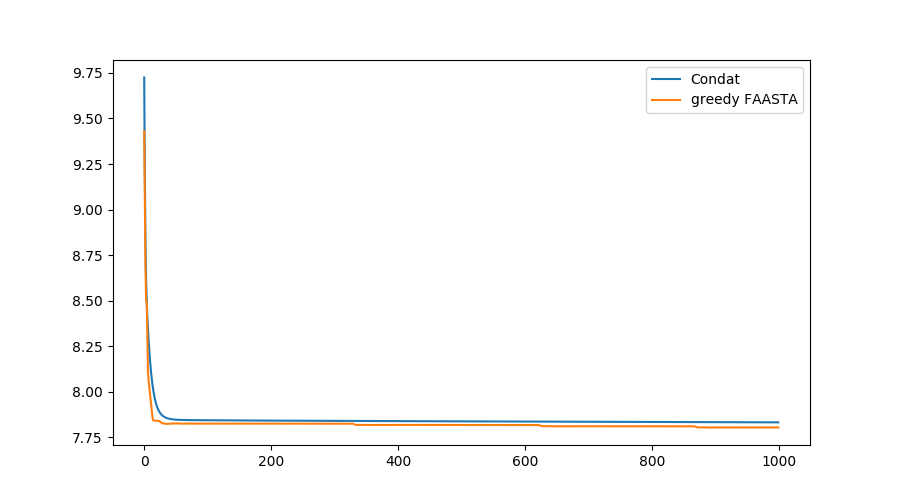

In [20]:
metric_name = 'cost'
plt.figure(figsize=(9, 5))
plt.plot(
#     np.log10(np.abs(np.array(metrics_condat[metric_name]['values'] - opt_metrics[metric_name]))), 
    np.log10(np.abs(np.array(metrics_condat[metric_name]['values']))), 
    label='Condat', 
)
plt.plot(
#     np.log10(np.abs(np.array(metrics_iterative[metric_name]['values'] - opt_metrics[metric_name]))), 
    np.log10(np.abs(np.array(metrics_iterative[metric_name]['values']))), 
    label='greedy FAASTA', 
)
plt.legend()

In [18]:
metrics_iterative['nrmse']['values'][-1]

155.29523659835667